In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""Funciones miscelaneas"""

#Función auxiliar que busca indice del primer elemento de v que coincida con a
def first_index(v, a):

    for ii in range(v.shape[0]): ## shape o length (velocidad de la función)
      if v[ii] == a:
        return ii

#Extrae los vectores X y Y de un vector de estado dado
def extract_xy(vec_estado):

    N = int(np.sum(vec_estado))
    X = np.array(range(N))+1
    Y = np.zeros(N)

    #Llena el vector Y: con el número de unidades de ataque que tienen ii
    #unidades de fuerza
    for ii in X:

        #Mascara que nos indicara los elemento que tenga una fuerza de
        #ataque ii
        mask = vec_estado == ii

        #Obtenemos una copia del vector de estado con los elementos que tengan
        #fuerza de ataque ii y guardamos su tamaño en le vector Y
        Y[ii-1] = vec_estado[mask].shape[0]

    return X, Y

#Función de regresión lineal
def linear_regression(X, Y, pot):

    if pot == True:
        X = np.log(X[Y!=0])
        Y = np.log(Y[Y!=0]/N)

    Sx = np.sum(X)
    Sy = np.sum(Y)
    Sxy = np.sum(X*Y)
    Sqx = np.sum(X*X)
    Sqy = np.sum(Y*Y)

    m = (N*Sxy-Sx*Sy)/(N*Sqx-(Sx**2))
    b = (Sy*(Sx**2)-Sxy*Sx)/(N*Sqx-(Sx**2))
    r = (N*Sxy-Sx*Sy)/np.sqrt((N*Sqx-(Sx**2))*(N*Sqy-(Sy**2)))

    a = np.sqrt((np.sum((Y-m*X-b)**2))/(N-2))

    m_error = (np.sqrt(N)*a)/np.sqrt(N*Sqx-(Sx**2))

    return np.array([np.power(np.e,b), m, -r, m_error])

def data_regression_line(X, Y, vec_estado):
    #Eliminamos los valores en X y en Y en donde el valor Y sea cero
    Xl=X[Y!=0]
    Yl=Y[Y!=0]

    #Regresión lineal
    b, m, r, m_error = linear_regression(X, Y, True)

    #Se obtiene el valor de X para el cual Y normalizado tiene un valor minimo mediante la relacion y=b*x^m
    lnyb = np.log(np.min(Yl/N))-np.log(b)
    xmin = np.exp(lnyb*(1/m))

    #Con el x obtenido se saca una copia del arreglo x que solo contengan los x menores a este vlaor
    maskn = Xl <= xmin
    Xn = Xl[maskn]

    #Se evalua esta nuevo arreglo en la función para obtener solo los puntos necesarios de la regresión
    Yn = b*np.power(Xn,m)

    return Xn, Yn, b, m, r, m_error

In [3]:
"""Funciones graficadoras"""

def plot_simulation(vec_estado):

    X, Y = extract_xy(vec_estado)

    Xn,Yn, b, m, r, m_error = data_regression_line(X,Y, vec_estado)

    #Graficar resultados, normalizando Y, esto es, la gráfica de X vs Y/N
    fig, ax = plt.subplots()
    plt.xscale('log')
    plt.yscale('log')
    plt.plot(X[Y!=0],Y[Y!=0]/N, '.k')
    plt.plot(Xn, Yn, '-k', alpha = 0.5 , label =f"Regresión lineal con $\\alpha=${m:.3f} $\pm$ {m_error:.3f} $X^2=${r:.3f}")

    #Estilo de la gráfica
    plt.title("Número de unidades de ataque de fuerza s versus s")
    plt.xlabel("s")
    plt.ylabel("$n_{s}$")
    plt.legend()

    plt.savefig("plt_simulation.png")

#Documentación
def plot_alpha(v, alpha_vec):

    m, m_error = alpha_vec
    #Graficar resultados
    fig, ax = plt.subplots()
    #plt.xscale('log')
    #plt.yscale('log')
    plt.plot(v, m, '.k',label =f"Barras de error |")
    plt.errorbar(v, m, yerr=100*m_error, fmt = ".k")

    #Estilo de la gráfica
    plt.title("Dependencia del exponente $\\alpha$ respecto a la probabilidad v")
    plt.xlabel("v")
    plt.ylabel("$\\alpha$")
    plt.legend()

    plt.savefig("plt_alpha.png")

In [4]:
def simulation(N, nsteps, v):

    #Inicialización del vector de estado como N unidades de ataque con fuerza de ataque igual a 1
    vec_estado = np.ones(N)

    ii = 0

    while ii <= nsteps:


        #Selección de una unidad de ataque i. La probabilidad de ser escogido depende de la fuerza de ataque si y se calcula como si/N
        si = np.random.choice(vec_estado, p=vec_estado/N) #por lectura se puede transformar esta función en un lambda
        i_index = first_index(vec_estado, si)

        #Escoger la probabilidad v
        l = np.random.choice([0,1], p=[v, 1-v])

        #Fragmentación: se elimina la unidad de ataque i y se agregan si unidades de ataque con fuerza igual a 1
        if l == 0:
            vec_estado = np.delete(vec_estado, i_index)
            vec_estado = np.append(vec_estado, np.ones(int(si)))

        #Unión: se comprueba que existan dos o más unidades de ataque, se elimina la unidad de ataque i y se escoge una nueva unidad de ataque j (con el mismo criterio que i),
        #       se elimina la unidad j y se agrega una unidad de ataque con fuerza igual a si + sj
        if l == 1 and vec_estado.shape[0] >= 2:
            vec_estado = np.delete(vec_estado, i_index)
            sj = np.random.choice(vec_estado, p=vec_estado/(N-si))
            j_index = first_index(vec_estado, sj)
            vec_estado = np.delete(vec_estado, j_index)
            vec_estado = np.append(vec_estado, si+sj)

        ii = ii+1
    return vec_estado

def alpha(N, nsteps, v):
    vec_estado = simulation(N, nsteps, v)
    X, Y = extract_xy(vec_estado)
    RegLin = linear_regression(X, Y, True)
    return RegLin[1], RegLin[3]

alpha=np.vectorize(alpha)



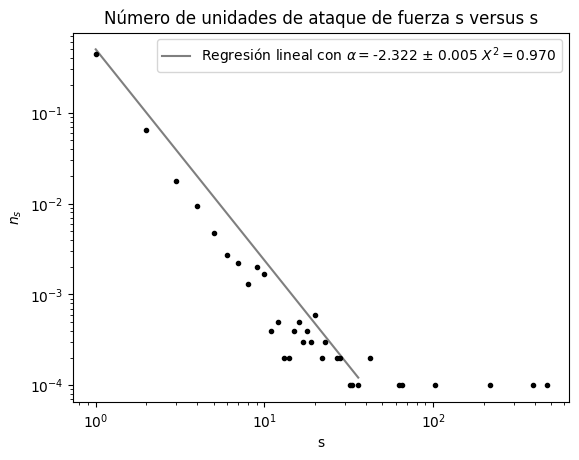

In [ ]:
#Valores de configuración
N0     = 10000
nsteps = 10000
v      = 0.01

N = N0*1

#Simulación gemela a la del paper
vec_estado0 = simulation(N, nsteps, v)

#Gráfica del caso gemelo
plot_simulation(vec_estado0)

In [ ]:
#Casos de prueba y comprobación
vec_estado1 = simulation(N, nsteps, 0.25)
vec_estado2 = simulation(N, nsteps, 0.5)
vec_estado3 = simulation(N, nsteps, 0.75)
vec_estado4 = simulation(N, nsteps, 0.99)

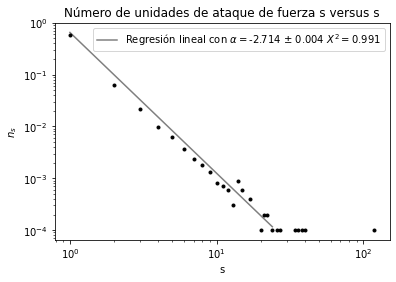

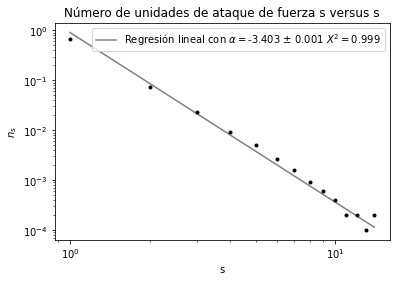

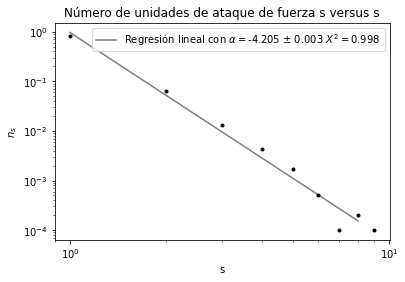

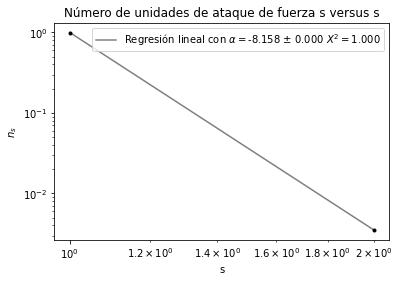

In [ ]:
#Gráficas de los casos de prueba
plot_simulation(vec_estado1)
plot_simulation(vec_estado2)
plot_simulation(vec_estado3)
plot_simulation(vec_estado4)

In [ ]:
#Caso de prueba extremo
vec_estado4 = simulation(1000000, 1000000, 0.99)
plot_simulation(vec_estado4)

KeyboardInterrupt: ignored

In [ ]:
#Análisis de la dependencia de alpha respecto a v
v = np.linspace(0, 1, 100)
alpha_vec = alpha(N, nsteps, v)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
#Gráfica del análisis alpha versus v
plot_alpha(v, alpha_vec)

NameError: ignored